# **Swissgerman Sätze GPT**
---

from Andrej Karpathy's Tutorial: [ Let's build GPT: from scratch, in code, spelled out. ](https://www.youtube.com/watch?v=kCc8FmEb1nY)

- As per the tutorial, the tokenizer used was character-level, which I made a notebook for separately here: [ShakespeareGPT [character-level]](https://www.kaggle.com/code/shreydan/shakespearegpt-character-level). The results were pretty incredible with character-level but it invented new words (just like Shakespeare :P).
- In this notebook, the model is slightly larger, uses a Byte-Pair Encoding tokenizer via HuggingFace trained on the shakespeare corpus from scratch, following their [tutorial on how to build GPT2 tokenizer from scratch](https://huggingface.co/course/chapter6/8?fw=pt#building-a-bpe-tokenizer-from-scratch), hopefully the words in this are more coherent.
- the purpose ofc here is to learn language-modelling, shakespeareGPT spits out text that looks like Shakespeare plays but they mostly dont make sense. We need to later fine tune the language model to output meaningful generated texts.
- I still need to figure out how to use multiple GPUs to utilize the 2x T4s but this runs well on P100.
- The full code I wrote following the incredible tutorial is here: [github/shreydan/shakespeareGPT](https://github.com/shreydan/shakespeareGPT)
- This is a neat little playground to try it yourself and play with the hyperparameters!

In [19]:
!pip install torchinfo -q

/bin/bash: /home/marco/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: /usr/bin/python3 -m pip install --upgrade pip


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from dataclasses import dataclass

from tqdm.auto import tqdm

from pathlib import Path

import matplotlib.pyplot as plt

from tokenizers import Tokenizer
from tokenizers.models import WordPiece
import tokenizers.pre_tokenizers as pre_tokenizers
import tokenizers.processors as processors
import tokenizers.decoders as decoders
from tokenizers.trainers import WordPieceTrainer

from torchinfo import summary
import pandas as pd

torch.manual_seed(1357)

# Data

In [9]:
data = pd.read_parquet('data/leipziz-swiss.parquet')

In [22]:
data = data[:-100].to_string(index=False)

In [24]:
with open('data/leipziz-swiss.txt','w',encoding='utf-8') as f:
    f.write(data)

# Word Piece Tokenizer

In [25]:
tokenizer_path = Path('./tokenizer/')
tokenizer_path.mkdir(exist_ok=True)

tokenizer = Tokenizer(WordPiece())

tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=False)
tokenizer.post_processor = processors.ByteLevel(trim_offsets=False)
tokenizer.decoder = decoders.ByteLevel()
trainer = WordPieceTrainer(special_tokens=['<|endoftext|>'], min_frequency=2)

tokenizer.train(['data/leipziz-swiss.txt'],trainer)
tokenizer.save(str(tokenizer_path / 'leipziz-swiss.json'))

In [27]:
tokenizer.token_to_id("1016 het dr französisch König Robert II. d Erbe vom Herzog Henri le Vénérable gschlage. 1031 het zweit Sohn vom französischen König Robert II. us em Huus vo de Kapetinger, dr Robert, s Herzogtum Burgund as Apanage übercho.")

# Config

In [76]:
@dataclass
class Config:
    
    block_size = 256 # context-length
    batch_size = 64 # mini-batch size
    
    vocab_size = tokenizer.get_vocab_size()
    
    train_size = 0.9 
    
    n_embed = 384
    n_heads = 6
    head_size = n_embed // n_heads # computes to 384/6=64
    
    n_layers = 3
    
    train_iters = 5000 # no. of batches to train on
    val_iters = 500 # no. of batches to validate on every eval_intervals
    
    eval_interval = 1000 # validate after every eval_interval iterations while training
    
    lr = 5e-4
    
    attn_dropout = 0.2
    block_dropout = 0.2
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
Config.device, Config.vocab_size

('cuda', 3413)

# Dataset

In [77]:
class LiederDataset:
    def __init__(self, Config, is_test=False) -> None:
        self.file_path = Path('data/liedertexte.txt')
        self.tokenizer_path = Path('tokenizer/liedertexte.json')
        with open(self.file_path,'r',encoding='utf-8') as f:
            self.data = f.read()
        self.tokenizer = Tokenizer.from_file(str(self.tokenizer_path))
        
        self.full_data = torch.tensor(self.tokenizer.encode(self.data).ids, dtype=torch.long)
        
        self.is_test = is_test
        if self.is_test:
            self.data = self.full_data[int(Config.train_size*len(self.full_data)):]
        else:
            self.data = self.full_data[:int(Config.train_size*len(self.full_data))]

        self.block_size = Config.block_size
        self.batch_size = Config.batch_size

    def __len__(self) -> int:
        return len(self.data)

    def get_block_size(self) -> int:
        return self.block_size

    def get_vocab_size(self) -> int:
        return self.tokenizer.get_vocab_size()

    def __next__(self):
        ix = torch.randint(len(self.data) - self.block_size, (self.batch_size,))
        x = torch.stack([self.data[i:i+self.block_size] for i in ix])
        y = torch.stack([self.data[i+1:i+self.block_size+1] for i in ix])
        return x,y

---

# **GPT Model**

## Single Attention Head

In [78]:
class AttentionHead(nn.Module):
    def __init__(self, Config):
        super().__init__()

        self.block_size = Config.block_size
        self.n_embed = Config.n_embed
        self.head_size = Config.head_size
        
        self.key = nn.Linear(self.n_embed, self.head_size, bias=False)
        self.query = nn.Linear(self.n_embed, self.head_size, bias=False)
        
        self.value = nn.Linear(self.n_embed, self.head_size, bias=False)

        self.register_buffer(
            'tril',
            torch.tril(torch.ones(self.block_size,self.block_size))
        )
        
        self.dropout = nn.Dropout(Config.attn_dropout)

    def forward(self, x):

        B,T,C = x.shape

        k = self.key(x)
        q = self.query(x)

        wei = q@k.transpose(-2,-1) * (C ** 0.5)
        wei = wei.masked_fill(self.tril[:T,:T]==0,float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        
        v = self.value(x)
        out = wei @ v
        
        return out

## MultiHead Attention

In [79]:
class MultiHeadAttention(nn.Module):
    def __init__(self, Config):
        super().__init__()
        self.n_heads = Config.n_heads
        self.head_size = Config.head_size
        
        self.heads = nn.ModuleList([AttentionHead(Config) for _ in range(self.n_heads)])
        
        self.projection = nn.Linear(Config.n_embed, Config.n_embed)
        
        self.dropout = nn.Dropout(Config.attn_dropout)
    
    def forward(self,x):
        x = torch.cat([h(x) for h in self.heads],dim=-1)
        x = self.projection(x)
        x = self.dropout(x)
        return x

## Feed Forward Layer

In [80]:
class FeedForward(nn.Module):
    def __init__(self, Config):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(Config.n_embed,Config.n_embed * 4),
            nn.ReLU(),
            nn.Linear(Config.n_embed * 4, Config.n_embed), # projection
            nn.Dropout(Config.block_dropout)
        )
    def forward(self,x):
        return self.net(x)

# Transformer Block

In [81]:
class TransformerBlock(nn.Module):
    def __init__(self, Config):
        super().__init__()
        self.attn = MultiHeadAttention(Config)
        self.ff = FeedForward(Config)
        self.ln1 = nn.LayerNorm(Config.n_embed)
        self.ln2 = nn.LayerNorm(Config.n_embed)

    def forward(self,x):
        x = x + self.attn(self.ln1(x))
        x = x + self.ff(self.ln2(x))
        
        return x

## GPT Model

In [82]:
class ShakespeareGPT(nn.Module):
    def __init__(self,Config):
        super().__init__()
        
        self.n_embed = Config.n_embed
        self.block_size = Config.block_size
        
        self.token_embedding_table = nn.Embedding(Config.vocab_size,self.n_embed)
        self.pos_embedding_table = nn.Embedding(self.block_size, self.n_embed)
        
        self.blocks = nn.Sequential(
            *[TransformerBlock(Config)]*Config.n_layers,
            nn.LayerNorm(self.n_embed)
        )

        self.lm_head = nn.Linear(self.n_embed,Config.vocab_size)
        
    def forward(self,idx):
        
        B,T = idx.shape
        
        token_embs = self.token_embedding_table(idx)
        pos_embs = self.pos_embedding_table(torch.arange(T,device=Config.device))
        
        
        x = token_embs + pos_embs
        x = self.blocks(x)
        logits = self.lm_head(x)
        
        return logits

        
    def generate(self,idx,total):
        for _ in range(total):
            idx_cond = idx[:, -self.block_size:]
            logits= self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx
            

# Training

In [83]:
train_ds = LiederDataset(Config)
val_ds = LiederDataset(Config,is_test=True)

In [84]:
lm = ShakespeareGPT(Config)
lm = lm.to(device=Config.device)

In [85]:
summary(lm,input_size=(Config.batch_size, Config.block_size),dtypes=[torch.long],depth=5,)

Layer (type:depth-idx)                        Output Shape              Param #
ShakespeareGPT                                [64, 256, 3413]           --
├─Embedding: 1-1                              [64, 256, 384]            1,310,592
├─Embedding: 1-2                              [256, 384]                98,304
├─Sequential: 1-3                             [64, 256, 384]            --
│    └─TransformerBlock: 2-1                  [64, 256, 384]            --
│    │    └─LayerNorm: 3-1                    [64, 256, 384]            768
│    │    └─MultiHeadAttention: 3-2           [64, 256, 384]            --
│    │    │    └─ModuleList: 4-9              --                        (recursive)
│    │    │    │    └─AttentionHead: 5-1      [64, 256, 64]             73,728
│    │    │    │    └─AttentionHead: 5-2      [64, 256, 64]             73,728
│    │    │    │    └─AttentionHead: 5-3      [64, 256, 64]             73,728
│    │    │    │    └─AttentionHead: 5-4      [64, 256, 64]   

### Optimizer

In [86]:
optim = torch.optim.AdamW(lm.parameters(), lr=Config.lr)

### Loss Function

In [87]:
def loss_fn(logits, targets):
    B,T,C = logits.shape
    logits = logits.view(B*T, C)
    targets = targets.view(B*T)
    loss = F.cross_entropy(logits,targets)
    return loss

# Training Loops

## Validation Loop

averages over `val_iters` mini-batches

In [88]:
@torch.no_grad()
def valid_N_iters():
    val_step_losses = []
    for batch in tqdm(range(Config.val_iters)):
        inputs, targets = next(val_ds)
        inputs, targets = inputs.to(device=Config.device), targets.to(device=Config.device)
        logits = lm(inputs)
        loss = loss_fn(logits,targets)
        val_step_losses.append(loss.item())
        
        del inputs, targets, loss, logits
    
    val_loss = torch.tensor(val_step_losses).mean()
    print(f'val loss: {val_loss}')
    return val_loss

## Training Loop

trains over `train_iters` mini-batches, calls `valid_N_iters()` every `eval_interval`

In [89]:
def train_N_iters():
    lm.train()
    train_step_losses = []
    val_losses = []
    for batch in tqdm(range(Config.train_iters)):
        optim.zero_grad()
        inputs, targets = next(train_ds)
        inputs, targets = inputs.to(device=Config.device), targets.to(device=Config.device)
        logits = lm(inputs)
        loss = loss_fn(logits,targets)
        loss.backward()
        optim.step()
        train_step_losses.append(loss.item())
        
        if batch%(Config.train_iters//10)==0 or batch==Config.train_iters-1:
            print(f"\n{'-'*50}\nbatch {batch} train step loss: {loss.item()}")
            print(f"train loss so far: {torch.tensor(train_step_losses).mean()}\n{'-'*50}\n")
            
        if batch%Config.eval_interval==0 or batch==Config.train_iters-1:
            lm.eval()
            val_loss = valid_N_iters()
            lm.train()
            val_losses.append(val_loss.item())
            
            del val_loss
            
        del inputs, targets, loss, logits
        
    return train_step_losses, val_losses

In [90]:
def save_lm():
    state_dict = lm.state_dict()
    save_path = Path('./').resolve() / 'swissGermanLiederGPT'
    save_path.mkdir(exist_ok=True)
    model_path = save_path / f'swissgermanliederGPT.pth'
    torch.save(state_dict, model_path)

In [91]:
def train_lm():
    train_step_losses,val_losses = train_N_iters()
    save_lm()
    return train_step_losses,val_losses

In [ ]:
tsl,vl=train_lm()

  0%|          | 0/5000 [00:00<?, ?it/s]


--------------------------------------------------
batch 0 train step loss: 8.323354721069336
train loss so far: 8.323354721069336
--------------------------------------------------



  0%|          | 0/500 [00:00<?, ?it/s]

val loss: 7.92919921875

--------------------------------------------------
batch 500 train step loss: 2.4998912811279297
train loss so far: 3.617999315261841
--------------------------------------------------


--------------------------------------------------
batch 1000 train step loss: 1.9604591131210327
train loss so far: 2.9302666187286377
--------------------------------------------------



  0%|          | 0/500 [00:00<?, ?it/s]

val loss: 8.604765892028809

--------------------------------------------------
batch 1500 train step loss: 1.949377179145813
train loss so far: 2.6020121574401855
--------------------------------------------------


--------------------------------------------------
batch 2000 train step loss: 1.7468385696411133
train loss so far: 2.410998582839966
--------------------------------------------------



  0%|          | 0/500 [00:00<?, ?it/s]

val loss: 9.652796745300293

--------------------------------------------------
batch 2500 train step loss: 1.7489840984344482
train loss so far: 2.2726047039031982
--------------------------------------------------


--------------------------------------------------
batch 3000 train step loss: 1.740820288658142
train loss so far: 2.1910197734832764
--------------------------------------------------



  0%|          | 0/500 [00:00<?, ?it/s]

val loss: 10.011834144592285

--------------------------------------------------
batch 3500 train step loss: 1.7330796718597412
train loss so far: 2.129605531692505
--------------------------------------------------


--------------------------------------------------
batch 4000 train step loss: 1.8590850830078125
train loss so far: 2.078758955001831
--------------------------------------------------



  0%|          | 0/500 [00:00<?, ?it/s]

val loss: 10.106084823608398


In [68]:
tsl_mean = torch.tensor(tsl).mean()
print('Train Loss:',tsl_mean.item())

Train Loss: 2.0008366107940674


# Loss Plots

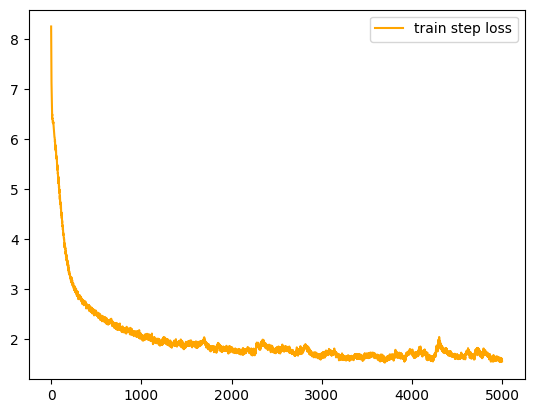

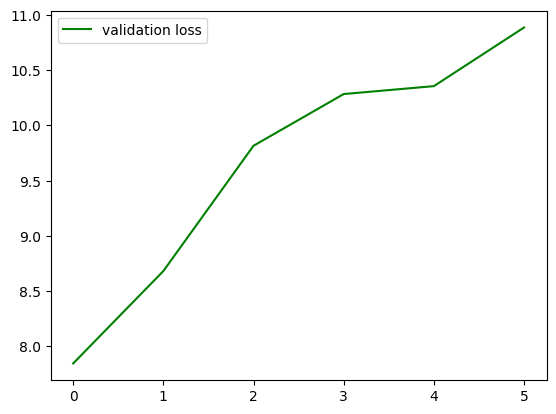

In [69]:
plt.plot(tsl,label='train step loss',color='orange')
plt.legend()
plt.show()
plt.plot(vl,label='validation loss',color='green')
plt.legend()
plt.show()

# Generating

In [70]:
generated_texts = []
for length in [100,300,500,700,1000]:
    generated = lm.generate(
    torch.zeros((1,1),dtype=torch.long,device=Config.device)+61, # initial context 61 (i believe its \n)
    total=length
)
    generated = tokenizer.decode(generated[0].cpu().numpy())
    text=f'generated ({length} tokens)\n{"="*50}\n{generated}\n{"="*50}\n\n'
    generated_texts.append(text)
    print(text)

generated (100 tokens)
tce Huus buut
uf dr
All dr Schultre
„ doch o nüt
und verschlasch viil
we me weiss nid wie du irgendwo ufemne Balkon gholt, wet wyter, i heig ne hie
Wirfsch eifach d’Ouge luege und zue mr das Glas no chli nöcher
Chumm doch no chli nöcher
vore, de Papier
Chum doch nie


 andrem, dür die Bed nid nöcher
Lue mal a uf wär drannen isch’flicke
Es


generated (300 tokens)
t me wartet, z’s däm Zimmer
Wene dr Motor nid uftue?

Dr Aabe zue a Hut, was d’Wohnigstür zue u blybe, wo eifach Darf i?
Chunnt scho denn mi i däm Meitschi, wo si bout, wo nid gha
I däm Park, aber nümm so lang
Dini Chel Gsicht drückt
deech uf ds Schwyzer Irgendbi mi nid

U das Echo vo de bini o nid!
de kenni di
Schwartet
We dr ganz einzle, aber nüt ussert öier Lugi wärde
Meinsch di no dr Erlö mi Wahrheit no ume bisch
U we dir das hätt niemer gwüsst
Meinsch öpper mi us de Tor
Ds Loub für was unde ar Halle bränkt u ha ghört, u när hi, i ha nes Chind schlyssig tue me gseht, u Brügge gleit
dass, läbsch fangs

In [26]:
with open('generated.txt','w') as f:
    for text in generated_texts:
        f.write(text)

---

Full code: [shakespeareGPT](https://github.com/shreydan/shakespeareGPT)

Follow [@shreydan](https://kaggle.com/shreydan) for more :)